# Evaluate Sentinel-2 Model Deployment Progress

* Count of chips versus scene cloud cover
* Fraction of deployment grid scored

## Import libraries

In [1]:
import os
import glob

import geopandas as gpd
import pandas as pd
import numpy as np

import boto3

from matplotlib import pyplot as plt

from IPython.display import clear_output

## Inputs and parameters

In [2]:
s3_path = 'S2-RGB-macro-localization-model-deployment4/'
consolidated_score_gjson = 'S2-deployment-chip-scores-CHN-10km-nowater-2020-consolidated.geojson'
s2_grid_gjson = '../../resources/macro-loc-model-deployment4/S2-deployment-grid-CHN-10km-nowater.geojson'
LOCAL_DIR = '/scratch/'

In [3]:
calc_crs = 'EPSG:3395'

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')

## Outputs

In [5]:
deployment_data_path = '../../resources/macro-loc-model-deployment4/'

chp_cnt_hist_png = deployment_data_path+'S2-deployment-CHN-10km-nowater-2020-chp-cnt-cloud-cover.png'

## Download consolidated deployment results and read it in

In [6]:
bucket.download_file(s3_path+consolidated_score_gjson,
                     LOCAL_DIR+consolidated_score_gjson)

In [7]:
unq_chip_gdf = gpd.read_file(LOCAL_DIR+consolidated_score_gjson)

In [23]:
chp_cnt = len(unq_chip_gdf)
print('Number of chips: ', str(chp_cnt))
print('Number of scenes: ', str(unq_chip_gdf.s2_grid_id.nunique()))

Number of chips:  415036
Number of scenes:  1094


## Evaluate chip count by scene cloud coverage

In [9]:
max(unq_chip_gdf.s2_eo_cloud_cover)

49.080382

In [10]:
bedges = np.arange(0, 51, 1)
cc_hist, cc_bedges = np.histogram(unq_chip_gdf.s2_eo_cloud_cover, 
                                  bins=bedges)
cc_hist_df = pd.DataFrame({'cc_lbedge': cc_bedges[:-1],
                           'cc_hist': cc_hist,
                           'cc_cum_hist': np.cumsum(cc_hist)})
cc_hist_df['cc_cum_frac'] = cc_hist_df.cc_cum_hist/chp_cnt

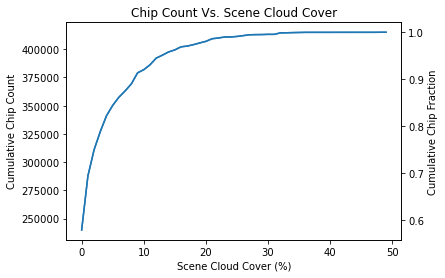

In [11]:
fig, ax = plt.subplots(1)

ax.plot(cc_hist_df.cc_lbedge, cc_hist_df.cc_cum_hist)
plt.title('Chip Count Vs. Scene Cloud Cover')
plt.xlabel('Scene Cloud Cover (%)')
plt.ylabel('Cumulative Chip Count')

ax2=ax.twinx()
ax2.plot(cc_hist_df.cc_lbedge, cc_hist_df.cc_cum_frac)
ax2.set_ylabel('Cumulative Chip Fraction')

fig.savefig(chp_cnt_hist_png)

# Compute Fraction of Deployment Region Scored

In [12]:
s2_deploy_grid_gdf = gpd.read_file(s2_grid_gjson)

In [13]:
s2_deploy_grid3395_gdf = s2_deploy_grid_gdf.to_crs(calc_crs)
s2_deploy_grid3395_gdf['area_sqkm'] = s2_deploy_grid3395_gdf.area/1e6

In [14]:
s2_deploy_grid3395_gdf.head()

,inds_id,inds_cmt_pred,inds_stl_pred,geometry,area_sqkm
0,2256,0.001345,0.000061,"POLYGON ((8221409.900 4794872.896, 8232541.849...",160.299674
1,2259,0.001365,0.000096,"POLYGON ((8221409.900 4751735.720, 8232541.849...",159.603813
2,2261,0.001375,0.000114,"POLYGON ((8221409.900 4723081.441, 8232541.849...",159.145649
3,2608,0.001613,0.000532,"POLYGON ((8232541.849 4809293.906, 8243673.798...",160.533950
4,2613,0.001393,0.000145,"POLYGON ((8232541.849 4737398.265, 8243673.798...",159.374161


In [15]:
unq_chip3395_gdf = unq_chip_gdf.to_crs(calc_crs)

In [16]:
scored_deploy_gdf = gpd.overlay(s2_deploy_grid3395_gdf, unq_chip3395_gdf, how='intersection')

In [17]:
scored_deploy_gs = gpd.GeoSeries(scored_deploy_gdf.unary_union)

In [18]:
deploy_reg_tot_area = sum(s2_deploy_grid3395_gdf.area_sqkm)
deploy_reg_scored_area = sum(scored_deploy_gs.area/1e6)
deploy_reg_scored_fraction = deploy_reg_scored_area / deploy_reg_tot_area

In [19]:
print('Total Area of Deployment Region: ', str(deploy_reg_tot_area), ' sq km')
print('Area Scored: ', str(deploy_reg_scored_area), ' sq km')
print('Fraction of Deployment Region Scored: ', str(deploy_reg_scored_fraction))

Total Area of Deployment Region:  3713194.9734158562  sq km
Area Scored:  3686298.8421736243  sq km
Fraction of Deployment Region Scored:  0.9927566067942052
